In [26]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from os import path
import shutil
import netCDF4
import numpy as np
import pandas as pd
np.set_printoptions(suppress=True)
import os
from ipywidgets import interact, widgets, fixed
import matplotlib.pyplot as plt

from climatenet.utils.data import ClimateDatasetLabeled, ClimateDataset
from climatenet.models import CGNet
from climatenet.utils.metrics import get_cm, get_iou_perClass
from climatenet.utils.model_evaluation import bootstrap_ious, compute_bootstrap_pct_positive_diff, plot_bootstrap_results, compute_bootstrap_confidence_intervals
from climatenet.utils.utils import Config
from climatenet.track_events import track_events
from climatenet.analyze_events import analyze_events
from climatenet.visualize_events import visualize_events

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Using bootstrapping to compare performance of two models

load 2 seperate models (for this example, I used the same model with a different config because I only had one model)

In [2]:
config1 = Config('../models/original_baseline_model/config.json')
model1 = CGNet(model_path='../models/original_baseline_model')
test1 = ClimateDatasetLabeled('../data/test', config1)

config2 = Config('../models/new_baseline_model/config.json')
model2 = CGNet(model_path='../models/original_baseline_model')
test2 = ClimateDatasetLabeled('../data/test', config2)

We can evalute the performance of the two models as shown below, but how do we know if the difference between the metrics is statistically significant?

In [3]:
eval1 = model1.evaluate(test1)
eval2 = model2.evaluate(test2)

print(eval1)
print(eval2)

100%|██████████| 61/61 [01:53<00:00,  1.86s/it]

(0.78616999114146, array([0.93057981, 0.33438732, 0.39306456]))
(0.7999157465872218, array([0.93840732, 0.03001085, 0.0002971 ]))


One way we can evaluate this is by using bootstapping, as shown below

In [4]:
cms1 = model1.get_cm_for_each_file(test1)
cms2 = model2.get_cm_for_each_file(test2)

100%|██████████| 61/61 [01:44<00:00,  1.71s/it]


fraction of bootstrap samples where model 2 outperforms model 1 on background class, class 1, class 2, and average across all classes:
[0.9908, 0.0, 0.0, 0.0]
confidence interval for model2 iou - model 1 iou 1 on background class, class 1, class 2, and average across all classes:
[[ 0.00135721  0.01441068]
 [-0.35197673 -0.25221277]
 [-0.41926955 -0.36519638]
 [-0.25069525 -0.20793881]]


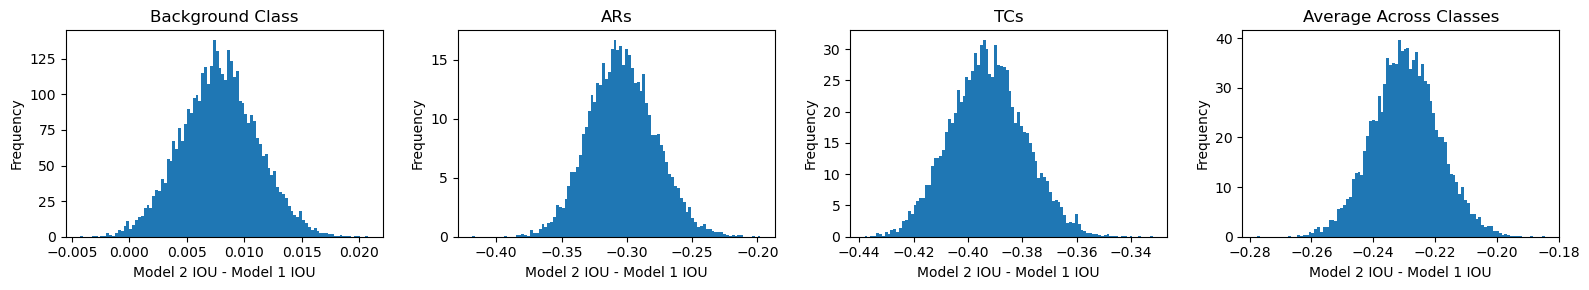

In [5]:
diff_iou = bootstrap_ious(cms1, cms2)
print("fraction of bootstrap samples where model 2 outperforms model 1 on background class, class 1, class 2, and average across all classes:")
print(compute_bootstrap_pct_positive_diff(diff_iou))
print("confidence interval for model2 iou - model 1 iou 1 on background class, class 1, class 2, and average across all classes:")
print(compute_bootstrap_confidence_intervals(diff_iou))
plot_bootstrap_results(diff_iou)

## Comparing the difference between a model's performance and the inter-annotator agreement (WIP)

Methodolgy:

For every test file with multiple annotators:

> For every annotation:

> > Set that annotation as the "reference annotation"

> > Compute CM between the reference annotation and the other annotations, store the results

> > Compute CM between the model predictions and the other annotations, store the results

Then, run some statistical tests on the stored results

In [81]:
def clear_directory(path):
    """Remove all files in a directory, keep the directory"""
    for root, dirs, files in os.walk(path):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))

In [82]:
config = Config('../models/original_baseline_model/config.json')
model = CGNet(model_path='../models/original_baseline_model')

In [83]:
if not os.path.exists('model_evaluation_temp'):
    os.mkdir('model_evaluation_temp')

In [84]:
test_file_names = os.listdir('../data/test')

In [85]:
test_file_dates = np.array([name[5:15] for name in test_file_names])
counts_per_date = pd.Series(test_file_dates).value_counts()
dates_with_multiple_annotations = list(counts_per_date[counts_per_date>1].index)

In [110]:
clear_directory("model_evaluation_temp")
aggregate_inter_annotation_cm = np.zeros((3, 3))
aggregate_model_cms = np.zeros((3, 3))

for date in dates_with_multiple_annotations:
    print(date)
    file_names_from_date = [file_name for file_name in test_file_names if file_name[5:15] == date]
    for reference_annotation in file_names_from_date:
        test_annotations = [file_name for file_name in file_names_from_date if file_name != reference_annotation]

        # get cm between reference annotation and other annotations
        cms = []

        annotation_data = netCDF4.Dataset('../data/test/' + reference_annotation)
        annotation_data = np.array(annotation_data.variables['LABELS'])
        annotation_data = annotation_data.reshape(1, annotation_data.shape[0], annotation_data.shape[1])
        annotation_data = torch.tensor(annotation_data)
        for file_name in test_annotations:
            test_data = netCDF4.Dataset('../data/test/' + file_name)
            test_data = np.array(test_data.variables['LABELS'])
            test_data = test_data.reshape(1, test_data.shape[0], test_data.shape[1])
            test_data = torch.tensor(test_data)

            cm = get_cm(annotation_data, test_data, 3)
            aggregate_inter_annotation_cm += cm

        # get cm between model and other annotations

        for file_name in test_annotations:
            shutil.copy('../data/test/' + file_name, 'model_evaluation_temp')

        test_model_temp = ClimateDatasetLabeled('model_evaluation_temp', config)
        cms = model.get_cm_for_each_file(test_model_temp)
        aggregate_model_cms += cms.sum(axis=0)
        clear_directory("model_evaluation_temp")

2011-09-30


100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


2012-06-24


100%|██████████| 3/3 [00:00<00:00,  4.20it/s]


2011-09-09


100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


2013-08-01


100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


2012-08-07


100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


2013-06-27


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]


2012-10-18


100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


2012-07-11


100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


2011-09-06


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


2013-09-16


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


2011-08-08


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


2013-07-03


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


2011-10-10


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


2013-09-04


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


2013-08-20


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


2011-07-26


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


2011-06-03


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


2013-06-15


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


2012-08-17


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


In [111]:
print("inter-annotator IOU:")
print(get_iou_perClass(aggregate_inter_annotation_cm), get_iou_perClass(aggregate_inter_annotation_cm).mean())
print("model IOU:")
print(get_iou_perClass(aggregate_model_cms), get_iou_perClass(aggregate_model_cms).mean())

inter-annotator IOU:
[0.93481544 0.24983705 0.33343702] 0.5060298362722484
model IOU:
[0.92989441 0.36303201 0.38999195] 0.5609727894386377


In [109]:
# next step: use bootstapping to get confidence intervals around the data above